In [10]:
import torch

# 1. Check if CUDA is available to PyTorch
print(f"CUDA Available: {torch.cuda.is_available()}")

# 2. Check the CUDA version PyTorch was compiled with
print(f"PyTorch CUDA Version: {torch.version.cuda}")

# 3. Check the cuDNN version PyTorch is using
print(f"cuDNN Version: {torch.backends.cudnn.version()}")

# 4. Get the name of your GPU
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

print("DEBUG: CuPy/CUDA status at script startup")
try:
    import cupy
    print("CuPy version:", cupy.__version__)
    print("CUDA runtime version:", cupy.cuda.runtime.runtimeGetVersion())
    print("CUDA driver version:", cupy.cuda.runtime.driverGetVersion())
    # print("GPU name:", cupy.cuda.runtime.getDeviceProperties(0)['name'].decode())
except Exception as e:
    print("CuPy/CUDA ERROR:", e)
print("="*60)

CUDA Available: True
PyTorch CUDA Version: 12.4
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 4070 SUPER
DEBUG: CuPy/CUDA status at script startup
CuPy version: 13.6.0
CUDA runtime version: 12090
CUDA driver version: 12060


In [11]:
import sys
import os 
# Add workspace root to Python path for imports
'''
By default, Python only searches for modules in the current directory and installed packages. 
Since your notebook is in the notebooks subfolder, you need to add the parent folder (your workspace root) to the Python path. 
This lets you import modules like open_ephys_loader or pfr_neurofunctions dirm ectly.
'''
workspace_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
sys.path.insert(0, workspace_root)
# Now you can import modules from your workspace directly

In [3]:
from open_ephys_loader import load_openephys_dat_lazy_with_tetrodes

# Your tetrode setup - NOW PRESERVED!
tetrode_groups = {
    'CA1': {'tet1': [17, 18, 19, 20], 'tet2': [21, 22, 23, 24]},
    'RTC': {'tet1': [14, 15, 16]},
    'PFC': {'tet1': [0, 1, 2, 3], 'tet2': [4, 5, 6, 7]},
}

selected_channels = {
    'CA1_tet1': 17, 'CA1_tet2': 21, 'RTC_tet1': 14,
    'PFC_tet1': 0, 'PFC_tet2': 5
}

data_lfp = load_openephys_dat_lazy_with_tetrodes(
    filepath=r"F:\Spikeinterface_practice\s4_rec\ephys.dat",
    num_channels=43,
    tetrode_groups=tetrode_groups,
    selected_channels=selected_channels,
    sampling_frequency=30000,
    target_sampling_frequency=1000,
    plot='widget',
    verbose=False
)
display(data_lfp)


LazyBinaryLoader initialized:
  File: F:\Spikeinterface_practice\s4_rec\ephys.dat
  Channels: 43, Samples: 89,806,848
  Duration: 2993.56s
  Regions: ['CA1', 'RTC', 'PFC']
  Tetrodes: ['CA1_tet1', 'CA1_tet2', 'RTC_tet1', 'PFC_tet1', 'PFC_tet2']
  Selected channels: 5


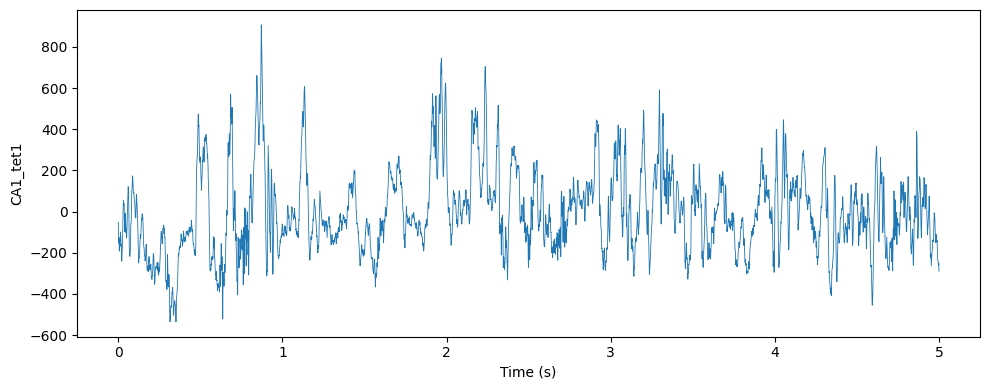

In [4]:
import numpy as np
import matplotlib.pyplot as plt

loader = data_lfp.loader # not sure why I need to do that, but it looks like the widget option doenst allow to get the physical recording and this solve the problem
start, end = 0, 5
trace = loader.get_selected_trace('CA1_tet1', start_time=start, end_time=end, resample_to=1000)
fs = trace.size / (end - start)
# trace = np.asarray(loader.get_selected_trace('CA1_tet1', start_time=0, end_time=5))
# fs = getattr(loader, "target_sampling_frequency", None)
t = np.arange(trace.size) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, trace, lw=0.6)
plt.xlabel("Time (s)")
plt.ylabel("CA1_tet1")
plt.tight_layout()

Step 1: Load and Inspect Spike Data__

In [5]:
import numpy as np
from pathlib import Path
from spike_analysis import SpikeAnalysis, process_spike_data, load_processed_spike_data

# Process to generate 'units.npy'
npy_path = r'F:\Spikeinterface_practice\s4_rec\phyMS5' # Path to the directory containing the analsis from  phy2
save_path = r'F:\Spikeinterface_practice\s4_rec'
process_spike_data(npy_path, save_path, samp_freq=30000)

# After running process_spike_data once, load cleanly without manual fixes:
units_file = r'F:\Spikeinterface_practice\s4_rec\units.npy'
processed_spike_data = load_processed_spike_data(units_file)

# Now pass directly to SpikeAnalysis
spike_analysis = SpikeAnalysis(
    processed_data=processed_spike_data,
    sampling_rate=30000,
    duration=data_lfp.duration
)

region_mapping = {2: 'PFC',
                  3: 'PFC',
                  7: 'CA1',
                  8: 'CA1',
                  6: 'RTC'}
spike_analysis.assign_brain_regions(region_mapping)

# Verify the mapping
for tetrode, region in region_mapping.items():
    units_in_tetrode = spike_analysis.tetrode_mapping.get(tetrode, [])
    print(f"Tetrode {tetrode} ({region}): {len(units_in_tetrode)} units")


Tetrode 2 (PFC): 4 units
Tetrode 3 (PFC): 6 units
Tetrode 7 (CA1): 3 units
Tetrode 8 (CA1): 3 units
Tetrode 6 (RTC): 1 units


In [6]:
# Import or copy the fixed function
from open_ephys_loader.brain_regions import plot_region_lfp_with_spike_raster
# Or customize colors
custom_colors = {
    'CA1': '#FF6B6B',  # Red
    'RTC': '#4ECDC4',  # Teal  
    'PFC': '#45B7D1',  # Blue
}

# loader = data_lfp.loader # optional, otherwise needs to run load_openephys_dat_lazy_with_tetrodes with plot=False
# Widget mode - interactive navigation
plot_region_lfp_with_spike_raster(
    loader, 
    selected_channels, 
    tetrode_groups, 
    spike_analysis, 
    regions=['CA1', 'RTC', 'PFC'],
    widget_mode=True,  # ✅ Now works with firing rate!
    window_size=2.0,
    show_firing_rate=True,
    firing_rate_kernel_width=0.06,
    region_colors=custom_colors
)


🖱️  Launching Custom Interactive Widget!
📏 Initial window: 2.0s
📊 Total duration: 2993.6s
🎛️  Region-based layout with navigation controls
💡 Tip: Close widget to continue


In [ ]:
# from position_analysis import (
#     load_position_data,
#     interpolate_position,
#     estimate_velocity,
#     plot_position_data,
#     create_track_graph,
#     linearize_positions_along_graph,
# )

# # Load
# tvel, linVel = load_position_data(r'F:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat', position_key='linVel', return_time=True)
# t_lfp=t
# _, velocity = interpolate_position(tvel, LinVel.squeeze(), target_vector=t_lfp)

# # Import the function (adjust the import path if needed)
# from position_analysis.plotting import plot_interpolation_alignment, plot_interpolation_corr

# # Call the function with your variables
# corr_pos, corr_lfp = plot_interpolation_alignment(
#     tvel, LinVel, t_lfp, velocity, show=True
# )

# corr_pos, corr_lfp = plot_interpolation_corr(
#     tvel, LinVel, t_lfp, velocity, show=True
# )

# print(f"Correlation (pos timeline): {corr_pos:.4f}")
# print(f"Correlation (LFP timeline): {corr_lfp:.4f}")

### SWR detection and stats (library-based)

In [12]:
# Single- and multi-region SWR detection + summary plots

# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from open_ephys_loader import fast_openephys_dat_lfp
from position_analysis import load_position_data, interpolate_position
from swr_detection import SWRParams, SWRDetector
from swr_detection.pipeline import (
    find_region_channels,
    build_region_lfp,
    compute_immobility_mask,
    detect_swr_by_region,
    quick_overlay_plot,
    compute_region_mua_from_spikes,   # optional (spikes → region MUA)
    _get_unit_spike_times             # optional (if using SpikeAnalysis)
)


# 1) User config
dat_path = r"F:\Spikeinterface_practice\s4_rec\ephys.dat"              # EDIT
num_channels = 43                                                      # EDIT
selected_channels = {                                                  # EDIT
    'CA1_tet1': 17, 'CA1_tet2': 21, 'RTC_tet1': 14, 'PFC_tet1': 0, 'PFC_tet2': 5
}
fs_in = 30000.0
fs_out = 1000.0  # 1 kHz is sufficient for 150–250 Hz ripple band
pos_mat_path = r"F:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat"  # position path, matlab processed
pos_key = "linVel"  # velocity (or change to the right key in your .mat)

# 2) Load downsampled LFP
loader = fast_openephys_dat_lfp(
    filepath=dat_path,
    num_channels=num_channels,
    tetrode_groups={},             # not used in fast loader
    selected_channels=selected_channels,
    sampling_frequency=fs_in,
    target_sampling_frequency=fs_out,
    cache_dir=None,
    dtype="int16",
    chunk_sec=120.0,
    overlap_sec=0.25,
    return_mode="loader",
)
fs = float(loader.sampling_frequency)
t_lfp = loader.time_vector()
print(f"LFP duration: {loader.duration:.2f}s at {fs:.1f} Hz")

LFP duration: 2993.56s at 1000.0 Hz


3) Velocity aligned to LFP timeline + immobility mask

In [ ]:
# from position_analysis import (
#     load_position_data,
#     interpolate_position,
# )
# t_pos, vel_pos = load_position_data(pos_mat_path, position_key=pos_key, return_time=True)
# _, velocity = interpolate_position(
#     np.asarray(t_pos).squeeze(),
#     np.asarray(vel_pos).squeeze(),
#     target_vector=np.asarray(t_lfp).squeeze(),
# )
# immobile = compute_immobility_mask(velocity, v_thresh=5.0)

4) Build per-region LFP arrays

In [13]:
region_channels = find_region_channels(list(getattr(loader, "selected_channels", {}).keys()))
region_lfp = build_region_lfp(loader, region_channels) # Obtain the LFP for each region
print({k: v.shape for k, v in region_lfp.items()})
print(region_lfp.keys)

{'CA1': (2, 2993562), 'RTC': (1, 2993562), 'PFC': (2, 2993562)}
<built-in method keys of dict object at 0x000002B40E3FE340>


Tetrode 7 (CA1): 3 units
Tetrode 8 (CA1): 3 units
Tetrode 6 (RTC): 1 units
Tetrode 2 (PFC): 4 units
Tetrode 3 (PFC): 6 units
CA1 MUA shape: (2993562,) (should match LFP length: 2993562)
RTC MUA shape: (2993562,) (should match LFP length: 2993562)
PFC MUA shape: (2993562,) (should match LFP length: 2993562)


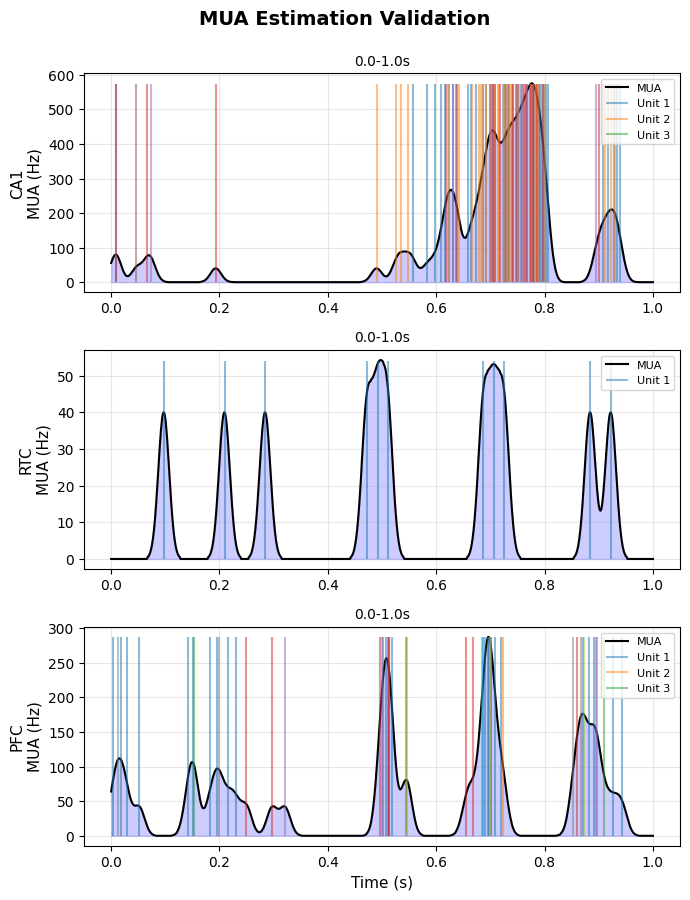

In [14]:
# 1. Setup (as before)
from spike_analysis import SpikeAnalysis, load_processed_spike_data

units_file = r'F:\Spikeinterface_practice\s4_rec\units.npy'
processed_data = load_processed_spike_data(units_file)

spike_analysis = SpikeAnalysis(
    processed_data=processed_data,
    sampling_rate=30000,
    duration=loader.duration
)

region_mapping = {7: 'CA1', 
                  8: 'CA1', 
                  6: 'RTC', 
                  2: 'PFC', 
                  3: 'PFC'}
spike_analysis.assign_brain_regions(region_mapping)
# Verify the mapping
for tetrode, region in region_mapping.items():
    units_in_tetrode = spike_analysis.tetrode_mapping.get(tetrode, [])
    print(f"Tetrode {tetrode} ({region}): {len(units_in_tetrode)} units")

# 2. NEW: Compute MUA (replaces manual extraction)
t_lfp = loader.time_vector()
mua_by_region = spike_analysis.compute_mua_all_regions(
    t_lfp=t_lfp,
    kernel_width=0.01
)

# Step 3: Verify MUA shapes match your LFP
for region, mua_vec in mua_by_region.items():
    print(f"{region} MUA shape: {mua_vec.shape} (should match LFP length: {len(t_lfp)})")

# Step 4: Use in single-region SWRDetector (example for CA1)
region = "CA1"
lfp_array = region_lfp[region]
mua_vec = mua_by_region[region]  # Now you have this!

#3. NEW: Visualize for validation
fig = spike_analysis.visualize_mua_segments(
    mua_by_region=mua_by_region,
    t_lfp=t_lfp,
    windows=[(0, 1)],
    show_spikes=True
)
plt.show()


Initialized SWR detector with 2 channels and 2993.56 seconds of data

Current Detection Parameters:

Core Parameters:
Ripple band: (125, 250) Hz
Threshold multiplier: 2.75 SD
Hysteresis thresholding: ENABLED
  High threshold: 3.5 SD
  Low threshold: 0.75 SD
Duration limits: 0.025-0.4 s

Signal Processing:
Notch frequency: 60 Hz
Sharp wave band: Disabled Hz
Trace window: 1.0 s

Event Detection:
Duration std threshold: 0.1 SD
Minimum event separation: 0.07 s
Merge threshold: 0.8

Classification Parameters:
Single separation: 200 ms
Burst intervals: 70-200 ms
Merge interval: 70 ms

MUA Parameters:
MUA detection: Enabled
MUA threshold: 2.5 SD
MUA min duration: 30 ms

HMM Edge Detection:
Use HMM edge detection: False

Movement Filtering:
Velocity threshold: None cm/s

Data Information:
Number of channels: 2
Recording duration: 2993.56 s
Sampling rate: 1000.0 Hz
MUA data: Provided
Velocity data: Not provided
Detecting events on 1 individual channels
Detected 1779 events
Channel 0: adaptive 

c:\Users\PedWKS\OneDrive - Massachusetts Institute of Technology\pfr_neurophys_data_analysis\swr_detection\swr_hmm_detection.py:2877: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


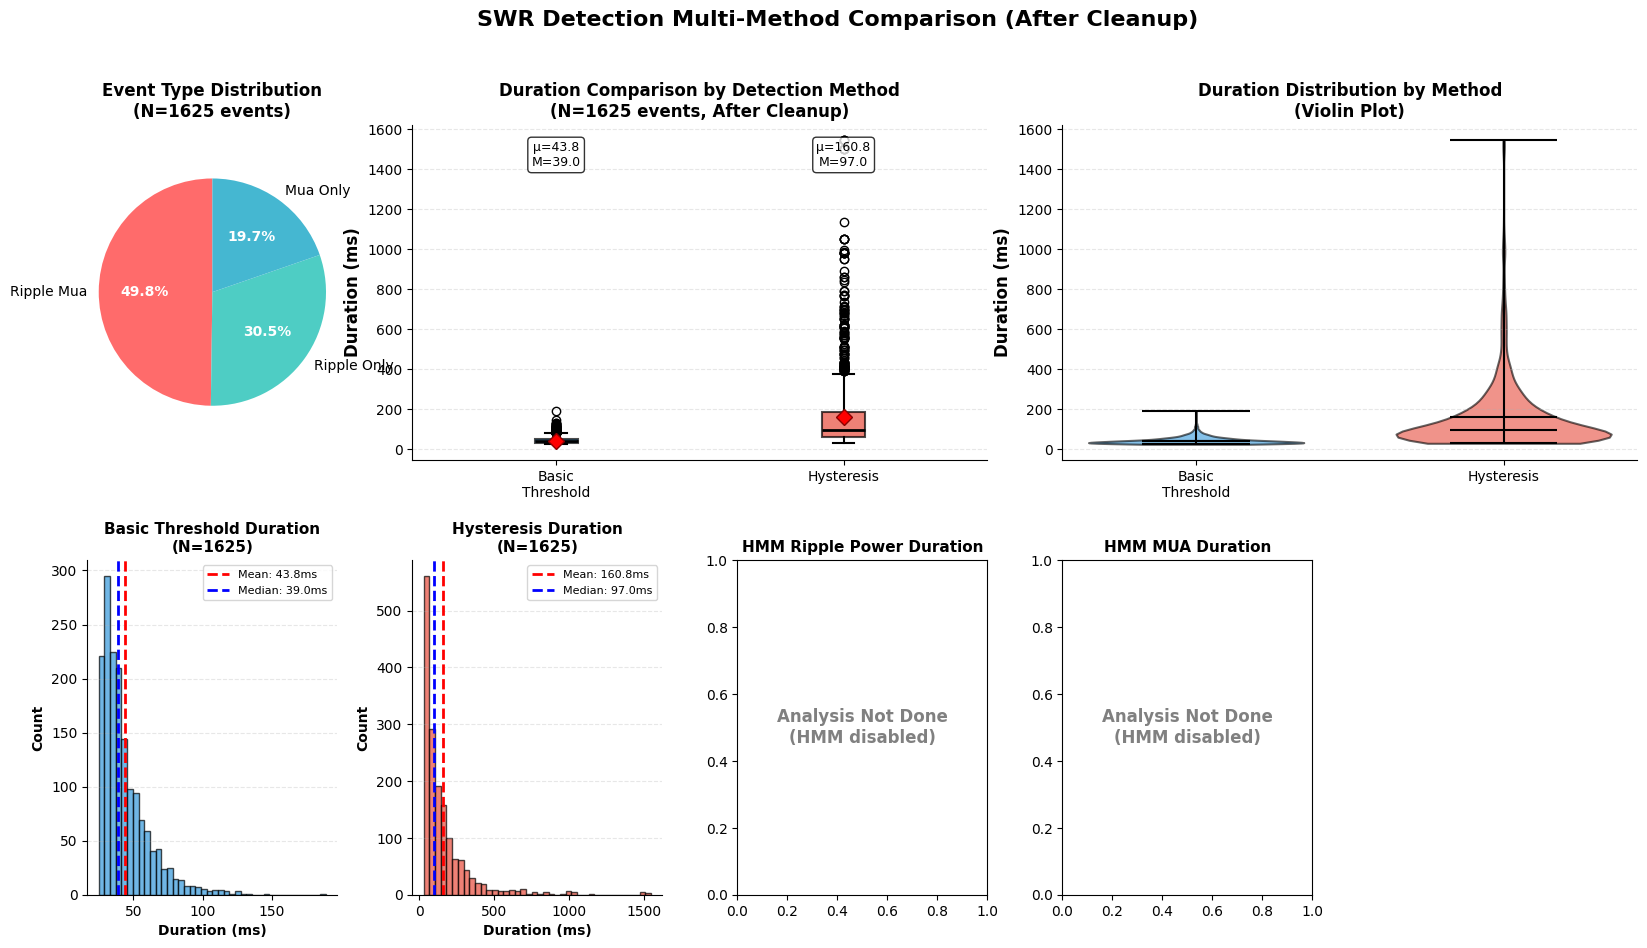


MULTI-METHOD DURATION COMPARISON SUMMARY

BASIC:
  N events: 1625
  Mean: 43.77 ms
  Median: 39.00 ms
  Std: 17.46 ms
  Range: [25.00, 189.00] ms

HYSTERESIS:
  N events: 1625
  Mean: 160.81 ms
  Median: 97.00 ms
  Std: 180.61 ms
  Range: [30.00, 1546.00] ms

HMM RIPPLE:
  HMM was not used for this run.

HMM MUA:
  HMM was not used for this run.



In [15]:

import swr_detection.swr_hmm_detection as _swr_hmm
from swr_detection.swr_hmm_detection import SWRHMMParams, SWRHMMDetector

ripple_th = 2.75  # High threshold in SD units
params = SWRHMMParams(
    # Ripple detection
    
    ripple_band=(125, 250),
    threshold_multiplier=ripple_th,  # Not used when hysteresis enabled
    # Enable Karlsson-style preprocessing
    use_smoothing=True,
    smoothing_sigma=0.01,  # 25ms Gaussian smoothing
    normalization_method='zscore',  # or 'median_mad' for robust
    min_duration=0.025,
    max_duration=0.4,
    min_event_separation=0.07,
    merge_interval=0.07,
    trace_window=1.0,
    adaptive_classification=True,
    dbscan_eps=0.15,
    
    # MUA detection
    mua_threshold_multiplier=2.5,
    mua_min_duration=0.03,
    enable_mua=True,
    
    # HMM parameters
    use_hmm_edge_detection=False,
    hmm_margin=0.1,
    use_global_hmm=False,
    global_hmm_fraction=0.1,
    hmm_states_ripple=2,
    hmm_states_mua=2,
    
    # Hysteresis parameters (NEW!)
    use_hysteresis=True,
    # hysteresis_high_multiplier=ripple_th,
    hysteresis_low_multiplier=0.75,
    hysteresis_confirmation_window=0.07
)

# --- Initialize detector ---
detector = SWRHMMDetector(
    lfp_data=lfp_array,   # shape: (n_channels, n_samples)
    fs=fs,
    mua_data=mua_vec,     # shape: (n_samples,)
    params=params
)

# --- Detect events (global HMM will be trained automatically if enabled) ---
# detector.detect_events(channels='all', average_mode=True) # 
detector.detect_events(channels=[0], average_mode=False)
detector.classify_events_improved()
stats = detector.analyze_basic_stats()
detector.plot_basic_stats(stats)

In [14]:
# --- View detected events as DataFrame ---
events_df = pd.DataFrame(detector.swr_events)
print(events_df.columns)
print(f"Number of events found: {len(detector.swr_events)}")

Index(['event_id', 'channel', 'start_idx', 'end_idx', 'start_time', 'end_time',
       'duration', 'basic_start_idx', 'basic_end_idx', 'basic_duration',
       'basic_start_time', 'basic_end_time', 'hysteresis_start_idx',
       'hysteresis_end_idx', 'hysteresis_duration', 'hysteresis_start_time',
       'hysteresis_end_time', 'hmm_ripple_start_idx', 'hmm_ripple_end_idx',
       'hmm_ripple_duration', 'hmm_mua_start_idx', 'hmm_mua_end_idx',
       'hmm_mua_duration', 'mua_high_start', 'mua_high_end',
       'ripple_start_idx', 'ripple_end_idx', 'ripple_start_time',
       'ripple_end_time', 'ripple_duration', 'mua_start_idx', 'mua_end_idx',
       'mua_start_time', 'mua_end_time', 'mua_duration', 'combined_start_idx',
       'combined_end_idx', 'combined_start_time', 'combined_end_time',
       'combined_duration', 'peak_time', 'peak_power', 'peak_times',
       'event_type', 'detection_type', 'ripple_high_threshold',
       'ripple_low_threshold', 'mua_threshold', 'ripple_peak_freq',


In [11]:
# --- Launch Event Inspector UI --- This is for visualizing and validating detected events
import importlib
import swr_detection.swr_hmm_detection as _swr
importlib.reload(_swr)
from swr_detection.swr_hmm_detection import launch_event_inspector
ui = launch_event_inspector(detector=detector)

In [ ]:
# run in the notebook cell This for undertand the stored event data structure
i = 2 # index of the event to inspect
ev = detector.swr_events[i]
print("event keys:", sorted(ev.keys()))

# show stored peak info
print("stored mua_peak_amplitude:", ev.get('mua_peak_amplitude'))
print("stored mua_peak_time:", ev.get('mua_peak_time'))
print("stored mua_peak_idx:", ev.get('mua_peak_idx'))

# check per-event traces / timestamps
print("has mua_trace?", ev.get('mua_trace') is not None)
print("has trace_timestamps?", ev.get('trace_timestamps') is not None)

if ev.get('mua_trace') is not None:
    mua = np.asarray(ev['mua_trace'])
    print("mua len:", len(mua), "min/max:", np.nanmin(mua), np.nanmax(mua))
if ev.get('trace_timestamps') is not None:
    ts = np.asarray(ev['trace_timestamps'])
    print("timestamps len:", len(ts), "start/end:", ts[0], ts[-1])

# compute peak time from mua_trace & timestamps (if available)
if ev.get('mua_trace') is not None and ev.get('trace_timestamps') is not None:
    mua = np.asarray(ev['mua_trace'])
    ts = np.asarray(ev['trace_timestamps'])
    idx = int(np.nanargmax(mua))
    print("argmax idx:", idx, "mapped time:", float(ts[idx]), "mua value at idx:", float(mua[idx]))
else:
    print("Cannot map mua peak -> timestamp (missing trace or timestamps).")

event keys: ['basic_duration', 'basic_end_idx', 'basic_end_time', 'basic_start_idx', 'basic_start_time', 'channel', 'classification', 'combined_duration', 'combined_end_idx', 'combined_end_time', 'combined_start_idx', 'combined_start_time', 'detection_type', 'duration', 'end_idx', 'end_time', 'event_id', 'event_type', 'hmm_mua_duration', 'hmm_mua_end_idx', 'hmm_mua_start_idx', 'hmm_ripple_duration', 'hmm_ripple_end_idx', 'hmm_ripple_start_idx', 'hysteresis_duration', 'hysteresis_end_idx', 'hysteresis_end_time', 'hysteresis_start_idx', 'hysteresis_start_time', 'mua_duration', 'mua_end_idx', 'mua_end_time', 'mua_high_end', 'mua_high_start', 'mua_peak_amplitude', 'mua_start_idx', 'mua_start_time', 'mua_threshold', 'mua_trace', 'peak_power', 'peak_time', 'peak_times', 'raw_trace', 'ripple_duration', 'ripple_end_idx', 'ripple_end_time', 'ripple_freq_class', 'ripple_high_threshold', 'ripple_low_threshold', 'ripple_peak_amplitude', 'ripple_peak_freq', 'ripple_peak_freq_power', 'ripple_power',

Loaded 1625 events into DataFrame.
Loaded notes DataFrame with 1625 events (includes arrays).


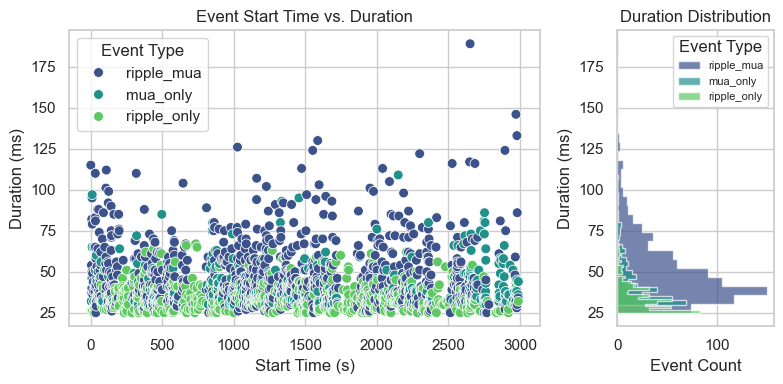

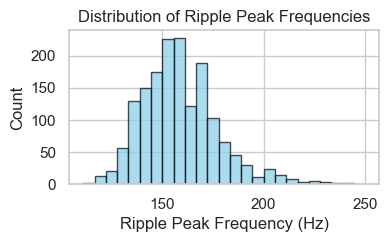

Visualization complete. Adjust parameters or add more plots as needed!


In [11]:
# Jupyter Notebook Code for Visualizing SWR Events from DataFrames

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'detector' is your SWRHMMDetector instance after running detection and classification
# Get the numeric summary DataFrame (for analysis/plots)
df = detector.get_events_dataframe()
if df.empty:
    print("No events detected. Run detection first.")
else:
    print(f"Loaded {len(df)} events into DataFrame.")

# Optional: Get the notes DataFrame (for trace-based plots, e.g., raw LFP arrays)
df_notes = detector.get_event_notes_dataframe()
if df_notes.empty:
    print("No notes DataFrame available.")
else:
    print(f"Loaded notes DataFrame with {len(df_notes)} events (includes arrays).")

# Set up plotting style
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 6)
df['basic_duration'] = [e.get('basic_duration', np.nan) for e in detector.swr_events]
df['hysteresis_duration'] = [e.get('hysteresis_duration', np.nan) for e in detector.swr_events]

# 1. Scatter Plot: Start Time vs. Duration (Colored by Event Type) + Duration Histogram on Right
# Assuming df is your events DataFrame
# Set up the figure with two subplots: scatter on left, histogram on right
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})

# Scatter plot on the left
sns.scatterplot(
    data=df,
    x='start_time',
    y=df['basic_duration'] * 1000,
    hue='event_type',
    palette='viridis',
    s=50,
    ax=ax1
)
ax1.set_xlabel('Start Time (s)')
ax1.set_ylabel('Duration (ms)')
ax1.set_title('Event Start Time vs. Duration')
ax1.legend(title='Event Type')

# Histogram on the right (horizontal for duration distribution)
event_types = df['event_type'].unique()
colors = sns.color_palette('viridis', n_colors=len(event_types))

for i, event_type in enumerate(event_types):
    subset = df[df['event_type'] == event_type]
    ax2.hist(
        subset['basic_duration'] * 1000,
        bins=30,
        alpha=0.7,
        color=colors[i],
        label=f'{event_type}',
        orientation='horizontal',
        histtype='stepfilled'
    )

ax2.set_xlabel('Event Count')
ax2.set_ylabel('Duration (ms)')
ax2.set_title('Duration Distribution')
ax2.legend(title='Event Type', fontsize=8)

plt.tight_layout()
plt.show()

# 2. Histogram of Ripple Peak Frequencies (if available)
if 'ripple_peak_freq' in df.columns and df['ripple_peak_freq'].notna().any():
    plt.figure(figsize=(4, 2))
    df_valid = df.dropna(subset=['ripple_peak_freq'])
    plt.hist(df_valid['ripple_peak_freq'], bins=25, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Ripple Peak Frequency (Hz)')
    plt.ylabel('Count')
    plt.title('Distribution of Ripple Peak Frequencies')
    plt.show()
else:
    print("No ripple peak frequency data available.")

# Optional: Save plots or DataFrames
# df.to_csv('events_summary.csv', index=False)  # Save numeric DataFrame
# df_notes.to_hdf('events_notes.h5', key='events')  # Save notes DataFrame (supports arrays)

print("Visualization complete. Adjust parameters or add more plots as needed!")

In [7]:
# --- Visual inspection widget for ripple and MUA detection ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, IntText, Output, Dropdown
from IPython.display import display
from scipy.signal import butter, filtfilt, hilbert
from scipy.ndimage import convolve1d, gaussian_filter1d

def classify_event(event):
    """Classify event as 'mua_only', 'ripple_only', 'cooccur', or other ripple types."""
    mua = (event.get('mua_high_start') is not None) and (event.get('mua_high_end') is not None)
    ripple = (event.get('combined_start_time') is not None) and (event.get('combined_end_time') is not None)
    ripple_only = (event.get('ripple_only_start') is not None) and (event.get('ripple_only_end') is not None)
    mua_only = (event.get('mua_only_start') is not None) and (event.get('mua_only_end') is not None)
    if mua and ripple:
        # Check for overlap
        mua_start, mua_end = event['mua_high_start'], event['mua_high_end']
        rip_start, rip_end = event['combined_start_time'], event['combined_end_time']
        if (mua_end >= rip_start) and (mua_start <= rip_end):
            return 'cooccur'
    if mua_only and not ripple and not ripple_only:
        return 'mua_only'
    if ripple_only and not mua and not mua_only:
        return 'ripple_only'
    if ripple_only and mua:
        return 'ripple+mua'
    if ripple_only:
        return 'ripple_only'
    if ripple:
        return 'ripple'
    return 'unknown'

def swr_detection_visual_inspection_widget(detector, window_sec=2.0):
    fs = detector.fs
    lfp = detector.lfp_data
    if lfp.ndim == 2:
        lfp = lfp.mean(axis=0)
    t = np.arange(lfp.shape[-1]) / fs
    # Compute ripple power if not present, and smooth if needed
    if hasattr(detector, 'ripple_power_global'):
        ripple_power = detector.ripple_power_global
    elif hasattr(detector, 'ripple_power'):
        ripple_power = detector.ripple_power
    else:
        ripple_band = detector.params.ripple_band
        b, a = butter(4, [ripple_band[0]/(fs/2), ripple_band[1]/(fs/2)], btype='band')
        filtered = filtfilt(b, a, lfp)
        ripple_env = np.abs(hilbert(filtered))
        ripple_power = ripple_env ** 2
    # Smooth ripple power if smoothing_sigma is set
    smoothing_sigma = getattr(detector.params, 'smoothing_sigma', None)
    if smoothing_sigma is not None and smoothing_sigma > 0:
        ripple_power = gaussian_filter1d(ripple_power, smoothing_sigma*fs)
    mua = detector.mua_data
    # Use thresholds from params if available
    if hasattr(detector.params, 'ripple_high_threshold'):
        high_th = detector.params.ripple_high_threshold
    else:
        mean_power = np.mean(ripple_power)
        std_power = np.std(ripple_power)
        high_th = mean_power + detector.params.threshold_multiplier * std_power
    if hasattr(detector.params, 'ripple_low_threshold'):
        low_th = detector.params.ripple_low_threshold
    else:
        mean_power = np.mean(ripple_power)
        std_power = np.std(ripple_power)
        low_th = mean_power + detector.params.hysteresis_low_multiplier * std_power
    # MUA threshold if present, else compute from data
    mua_th = getattr(detector.params, 'mua_threshold', None)
    if mua_th is None and mua is not None:
        mua_th = np.mean(mua) + 2 * np.std(mua)  # Example computation, adjust as needed

    # Pre-classify events for color coding
    event_types = []
    for e in detector.swr_events:
        event_types.append(classify_event(e))
    event_times = np.array([e.get('peak_time', (e.get('start_time', 0) + e.get('end_time', 0))/2) for e in detector.swr_events])
    event_type_arr = np.array(event_types)

    out = Output()
    n_windows = int((t[-1] - window_sec) // window_sec) + 1
    idx = IntText(value=0, description='Window:')
    prev_btn = Button(description='Previous')
    next_btn = Button(description='Next')
    window_dropdown = Dropdown(options=[1.0, 2.0, 5.0], value=window_sec, description='Win (s):')

    marker_dict = {
        'mua_only': {'color': 'red', 'label': 'MUA only', 'marker': 'v'},
        'ripple_only': {'color': 'blue', 'label': 'Ripple only', 'marker': 'v'},
        'cooccur': {'color': 'purple', 'label': 'Co-occur', 'marker': 'v'},
        'ripple+mua': {'color': 'orange', 'label': 'Ripple+MUA', 'marker': 'v'},
        'ripple': {'color': 'green', 'label': 'Ripple', 'marker': 'v'},
        'unknown': {'color': 'gray', 'label': 'Unknown', 'marker': 'v'}
    }

    def plot_window(i, window_sec):
        with out:
            out.clear_output(wait=True)
            start_time = i * window_sec
            end_time = min(start_time + window_sec, t[-1])
            mask = (t >= start_time) & (t < end_time)
            t_win = t[mask]
            ripple_win = ripple_power[mask]
            mua_win = mua[mask] if mua is not None else None
            # Find events in window
            in_window = (event_times >= start_time) & (event_times < end_time)
            event_idx_in_win = np.where(in_window)[0]
            plt.figure(figsize=(12, 6))
            # --- Top panel: Ripple power ---
            ax1 = plt.subplot(2, 1, 1)
            ax1.plot(t_win, ripple_win, color='purple', lw=1, label='Ripple Power')
            ax1.axhline(high_th, color='red', linestyle='--', lw=1, label='High Thresh (params)')
            ax1.axhline(low_th, color='blue', linestyle='--', lw=1, label='Low Thresh (params)')
            for typ in marker_dict:
                idxs = [idx_ev for idx_ev in event_idx_in_win if event_type_arr[idx_ev] == typ]
                if idxs:
                    ax1.plot(event_times[idxs], [ripple_power[int(event_times[j]*fs)] for j in idxs],
                             marker=marker_dict[typ]['marker'], color=marker_dict[typ]['color'], linestyle='None', markersize=12, label=marker_dict[typ]['label'])
            ax1.set_ylabel('Ripple Power')
            ax1.set_title(f'Ripple Power (window {start_time:.2f}-{end_time:.2f}s)')
            ax1.legend(loc='upper right', fontsize=8)
            # --- Bottom panel: MUA ---
            ax2 = plt.subplot(2, 1, 2, sharex=ax1)
            if mua_win is not None:
                ax2.plot(t_win, mua_win, color='green', lw=1, label='MUA')
            if mua_th is not None:
                ax2.axhline(mua_th, color='orange', linestyle='--', lw=1, label='MUA Thresh (params)')
            for typ in marker_dict:
                idxs = [idx_ev for idx_ev in event_idx_in_win if event_type_arr[idx_ev] == typ]
                if idxs:
                    ax2.plot(event_times[idxs], [mua[int(event_times[j]*fs)] for j in idxs],
                             marker=marker_dict[typ]['marker'], color=marker_dict[typ]['color'], linestyle='None', markersize=12, label=marker_dict[typ]['label'])
            handles, labels = ax2.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax2.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)
            ax2.set_ylabel('MUA (Hz)')
            ax2.set_xlabel('Time (s)')
            ax2.set_title('MUA Amplitude (triangle/shape: event types)')
            plt.tight_layout()
            plt.show()

    def on_prev(b):
        if idx.value > 0:
            idx.value -= 1
            plot_window(idx.value, window_dropdown.value)
    def on_next(b):
        if idx.value < n_windows - 1:
            idx.value += 1
            plot_window(idx.value, window_dropdown.value)
    def on_idx_change(change):
        if 0 <= idx.value < n_windows:
            plot_window(idx.value, window_dropdown.value)
        else:
            idx.value = min(max(idx.value, 0), n_windows - 1)
            plot_window(idx.value, window_dropdown.value)
    def on_window_change(change):
        nonlocal n_windows
        n_windows = int((t[-1] - change['new']) // change['new']) + 1
        idx.value = min(idx.value, n_windows - 1)
        plot_window(idx.value, change['new'])

    prev_btn.on_click(on_prev)
    next_btn.on_click(on_next)
    idx.observe(on_idx_change, names='value')
    window_dropdown.observe(on_window_change, names='value')
    controls = HBox([prev_btn, next_btn, idx, window_dropdown])
    display(VBox([controls, out]))
    plot_window(idx.value, window_dropdown.value)

# Usage:
swr_detection_visual_inspection_widget(detector, window_sec=2.0)

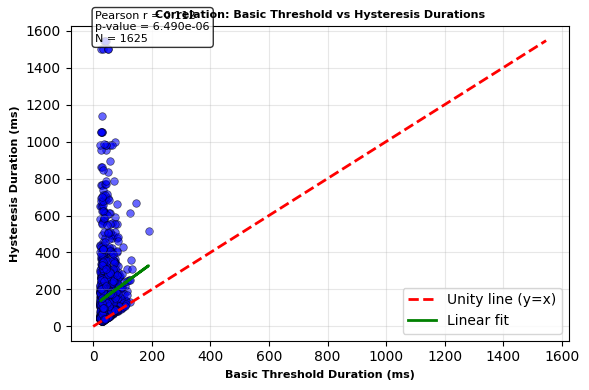

BASIC THRESHOLD vs HYSTERESIS DURATION COMPARISON
Total events analyzed: 1625
Pearson correlation coefficient: 0.1116
P-value: 6.4902e-06
Mean Basic duration: 43.8 ± 17.5 ms
Mean Hysteresis duration: 160.8 ± 180.6 ms
Mean difference (Hysteresis - Basic): 117.0 ms

Hysteresis expands events: 1573 (96.8%)
Hysteresis contracts events: 0 (0.0%)
No change: 52 (3.2%)

First 10 events:
 event_id  basic_duration_ms  hysteresis_duration_ms  difference_ms  difference_percent
        1              115.0                   191.0           76.0           66.086957
        2               32.0                    32.0            0.0            0.000000
        3               37.0                    88.0           51.0          137.837838
        4               26.0                   159.0          133.0          511.538462
        7               54.0                    75.0           21.0           38.888889
        8               96.0                   210.0          114.0          118.750000
  

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Get the events data
events = detector.swr_events

# Extract durations for each method
basic_durations = []
hysteresis_durations = []

for event in events:
    # Basic threshold duration
    basic_start = event.get('basic_start_time', event.get('start_time'))
    basic_end = event.get('basic_end_time', event.get('end_time'))
    basic_dur = (basic_end - basic_start) * 1000  # Convert to ms
    
    # Hysteresis duration
    hyst_start = event.get('hysteresis_start_time', basic_start)
    hyst_end = event.get('hysteresis_end_time', basic_end)
    hyst_dur = (hyst_end - hyst_start) * 1000  # Convert to ms
    
    basic_durations.append(basic_dur)
    hysteresis_durations.append(hyst_dur)

# Convert to arrays
basic_durations = np.array(basic_durations)
hysteresis_durations = np.array(hysteresis_durations)

# Calculate correlation
corr_coef, p_value = pearsonr(basic_durations, hysteresis_durations)

# Create scatter plot
plt.figure(figsize=(6, 4))

# Scatter plot
plt.scatter(basic_durations, hysteresis_durations, alpha=0.6, s=30, color='blue', edgecolors='black', linewidth=0.5)

# Unity line (y = x)
max_val = max(np.max(basic_durations), np.max(hysteresis_durations))
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Unity line (y=x)')

# Linear regression line
if len(basic_durations) > 1:
    z = np.polyfit(basic_durations, hysteresis_durations, 1)
    p = np.poly1d(z)
    plt.plot(basic_durations, p(basic_durations), "g-", linewidth=2, label='Linear fit')
Font_size=8
# Plot styling
plt.xlabel('Basic Threshold Duration (ms)', fontsize=Font_size, fontweight='bold')
plt.ylabel('Hysteresis Duration (ms)', fontsize=Font_size, fontweight='bold')
plt.title('Correlation: Basic Threshold vs Hysteresis Durations', fontsize=Font_size, fontweight='bold')

# Add correlation info to plot
plt.text(0.05, 0.95, f'Pearson r = {corr_coef:.3f}\np-value = {p_value:.3e}\nN = {len(basic_durations)}', 
         transform=plt.gca().transAxes, fontsize=Font_size, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("=" * 60)
print("BASIC THRESHOLD vs HYSTERESIS DURATION COMPARISON")
print("=" * 60)
print(f"Total events analyzed: {len(basic_durations)}")
print(f"Pearson correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean Basic duration: {np.mean(basic_durations):.1f} ± {np.std(basic_durations):.1f} ms")
print(f"Mean Hysteresis duration: {np.mean(hysteresis_durations):.1f} ± {np.std(hysteresis_durations):.1f} ms")
print(f"Mean difference (Hysteresis - Basic): {np.mean(hysteresis_durations - basic_durations):.1f} ms")

# Calculate percentage of events where hysteresis expands/contracts
expanded = np.sum(hysteresis_durations > basic_durations)
contracted = np.sum(hysteresis_durations < basic_durations)
same = np.sum(hysteresis_durations == basic_durations)

print(f"\nHysteresis expands events: {expanded} ({expanded/len(basic_durations)*100:.1f}%)")
print(f"Hysteresis contracts events: {contracted} ({contracted/len(basic_durations)*100:.1f}%)")
print(f"No change: {same} ({same/len(basic_durations)*100:.1f}%)")

# Create a DataFrame for further analysis if needed
duration_df = pd.DataFrame({
    'event_id': [event.get('event_id', i) for i, event in enumerate(events)],
    'basic_duration_ms': basic_durations,
    'hysteresis_duration_ms': hysteresis_durations,
    'difference_ms': hysteresis_durations - basic_durations,
    'difference_percent': ((hysteresis_durations - basic_durations) / basic_durations) * 100
})

print(f"\nFirst 10 events:")
print(duration_df.head(10).to_string(index=False))

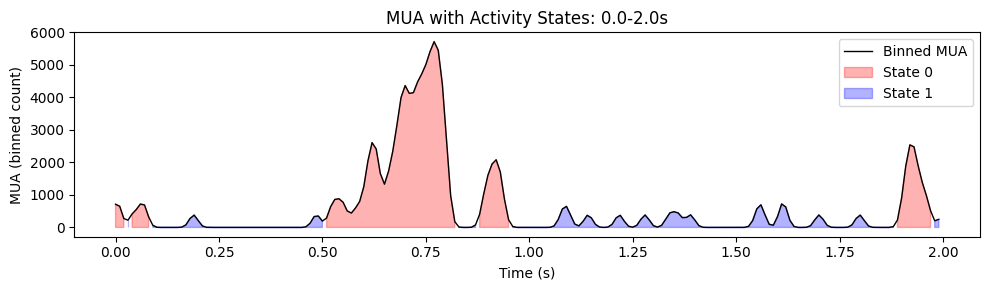

In [9]:
from swr_detection.mua_high_activity_refinement import (
    bin_mua,
    train_hmm_on_mua,
    extract_high_activity_periods,
    refine_event_with_mua_states,
    refine_all_events_with_mua_states,
    expand_state_edges,
    refine_event_with_global_states,
    refine_all_events_with_global_hmm,
    interactive_mua_state_browser
)
# 1. Bin MUA
bin_size = 0.01  # 5 ms bins
hmm_states = 2
mua_binned = bin_mua(mua_vec, bin_size=bin_size, fs=fs)

# 2. Train HMM/HSMM
model = train_hmm_on_mua(mua_binned, n_states=hmm_states, params=params)

# 3. Infer state sequence
states = model.predict(mua_binned.reshape(-1, 1))

# 4. Detect high activity periods
high_periods = extract_high_activity_periods(states, bin_size=bin_size, fs=fs)
# After you have mua_binned and states
states_expanded = expand_state_edges(states, target_state=0, expand_bins=0)
interactive_mua_state_browser(mua_binned, states_expanded, bin_size=bin_size, window_sec=2)

In [10]:
# Step 1: Refine ALL events with MUA using extended search window
from swr_detection.mua_high_activity_refinement import refine_all_events_with_global_hmm

refined_events = refine_all_events_with_global_hmm(
    detector.swr_events, 
    mua_vec, 
    fs, 
    bin_size=bin_size,        # 5ms bins
    n_states=hmm_states,            # 2-state HMM (low/high activity)
    search_margin=0.2,     # Search ±200ms around ripple
    expand_bins=0,          # Optional: add more bins for additional expansion
    expand_to_state_edges=True,
    save_to=detector
)

print(f"✓ Refined {len(refined_events)} events with MUA-based boundaries")
print(f"  - Search margin: ±{0.2*1000:.0f}ms around ripple boundaries")
print(f"  - Bin size: {0.005*1000:.1f}ms")
print(f"\nUse the interactive browser below to explore events with spike rasters!")

✓ Refined 1625 events with MUA-based boundaries
  - Search margin: ±200ms around ripple boundaries
  - Bin size: 5.0ms

Use the interactive browser below to explore events with spike rasters!


In [11]:
# Interactive browser with spike raster plots showing MUA-refined boundaries
from swr_detection.mua_high_activity_refinement import interactive_event_refinement_with_spikes

# Prepare spike_times_by_region format (CA1 only, since detector is for CA1)
spike_times_ca1_only = {}
region = 'CA1'  # Match the detector's region
spike_list = spike_analysis.get_spike_times_by_region(region)
region_units = spike_analysis.get_units_by_region(region)

# Create dictionary mapping unit_id -> spike_times for CA1 only
spike_times_ca1_only[region] = {
    unit_id: np.asarray(spike_times).flatten()
    for unit_id, spike_times in zip(region_units, spike_list)
}

print(f"Spike data prepared for {region}: {len(spike_times_ca1_only[region])} units")

# Custom region color (only CA1 needed)
custom_colors = {
    'CA1': '#FF6B6B',  # Red
}

# Launch enhanced visualization with spike rasters
interactive_event_refinement_with_spikes(
    detector, 
    mua_vec, 
    spike_times_ca1_only,
    region_colors=custom_colors,
    margin=0.5,
    show_global_states=True
)

Spike data prepared for CA1: 6 units


Event type: ripple_mua


In [12]:
import os
print("CPU count (logical cores):", os.cpu_count())
import psutil
print("Physical cores:", psutil.cpu_count(logical=False))
print("Logical cores:", psutil.cpu_count(logical=True))

CPU count (logical cores): 24
Physical cores: 12
Logical cores: 24


In [7]:
import importlib
import swr_detection.swr_spectral_features
importlib.reload(swr_detection.swr_spectral_features)
import swr_detection.pipeline
importlib.reload(swr_detection.pipeline)
from swr_detection.pipeline import bandpass_ripple_lfp

from swr_detection.swr_spectral_features import (
    batch_compute_spectral_features,
    average_spectrograms_by_type,
    compute_event_spectral_features,
    event_spectrogram_browser,
    compute_event_spectral_features_from_trace,
    event_lfp_and_spectrogram_widget
)
 
# Filter out events that are too short for spectral analysis
min_event_duration = 0.016  # 16ms minimum for spectrogram
valid_events = [e for e in detector.swr_events 
               if e.get('basic_duration', e.get('duration', 0)) > min_event_duration]

print(f"Total events: {len(detector.swr_events)}")
print(f"Events suitable for spectrogram: {len(valid_events)}")

# Compute spectral features only for valid events
lfp_array = region_lfp['CA1'][0]  # Use channel 0, or [1] for channel 1
ripple_trace = bandpass_ripple_lfp(lfp_array, fs)

# ========== CWT SPECTRAL ANALYSIS WITH VALIDATION ==========
import dask
from dask.diagnostics import ProgressBar
import numpy as np
# import psutil

# Configure Dask for parallel processing
dask.config.set(scheduler='threads', num_workers=20)

# Set CWT method for all events
for event in detector.swr_events:
    event['spec_method'] = 'cwt'

# Validate parameters before computation
fs_val = float(detector.fs if hasattr(detector, 'fs') else fs)
nyquist = fs_val / 2.0
freq_range = (120, 250)
target_freq_bins = 400
pre_ms = 100

print("=" * 60)
print("CWT SPECTRAL ANALYSIS CONFIGURATION")
print("=" * 60)
print(f"Sampling rate: {fs_val:.1f} Hz")
print(f"Nyquist frequency: {nyquist:.1f} Hz")
print(f"Frequency range: {freq_range[0]}-{freq_range[1]} Hz")
print(f"Target frequency bins: {target_freq_bins}")
print(f"Frequency resolution: ~{(freq_range[1] - freq_range[0]) / target_freq_bins:.1f} Hz/bin")
print(f"Number of workers: 20")
print(f"Smoothing sigma: 1.0")
print("=" * 60)

# Validate frequency range
if freq_range[1] > nyquist:
    print(f"⚠️ WARNING: Max frequency ({freq_range[1]} Hz) exceeds Nyquist ({nyquist:.1f} Hz)!")
    print(f"   Frequencies will be automatically clipped.")

# Compute spectral features
batch_compute_spectral_features(
    detector, 
    lfp_array, 
    fs,
    use_gpu='auto',
    gpu_batch_size='auto',
    use_optimized_cwt=True,
    n_workers=20,
    verbose=True,           # Show progress bar
    target_freq_bins=target_freq_bins,    # 60 bins across 100-250 Hz = ~2.5 Hz resolution
    n_bins=300,              # 40 time bins
    smoothing_sigma=0.0,    # Gaussian smoothing (1 bin width)
    freq_range=freq_range,
    pre_ms=pre_ms,             # ±250ms window
    post_ms=pre_ms
)

# Count events with spectrograms
n_with_spec = sum('spectrogram' in e and e['spectrogram'] is not None for e in detector.swr_events)
n_total = len(detector.swr_events)
print(f"\n✅ Spectrograms computed: {n_with_spec}/{n_total} events ({n_with_spec/n_total*100:.1f}%)")

# Validate spectrogram shapes
print("\nValidating spectrogram shapes:")
for i in range(min(5, len(detector.swr_events))):
    event = detector.swr_events[i]
    spec = event.get('spectrogram')
    freqs = event.get('spectrogram_freqs')
    if spec is not None and freqs is not None:
        print(f"  Event {i}: spec.shape={spec.shape}, freqs.shape={freqs.shape}, "
              f"freq_range=[{freqs[0]:.1f}, {freqs[-1]:.1f}] Hz")
    else:
        error = event.get('spectrogram_error', 'Unknown error')
        print(f"  Event {i}: Failed - {error}")

# Check for peak frequency bias
peak_freqs = []
for e in detector.swr_events:
    spec = e.get('spectrogram')
    freqs = e.get('spectrogram_freqs')
    if spec is not None and freqs is not None and spec.ndim == 2:
        # Find peak across all time bins
        power_avg = np.mean(spec, axis=1)
        peak_idx = np.argmax(power_avg)
        peak_freqs.append(freqs[peak_idx])

if peak_freqs:
    peak_freqs = np.array(peak_freqs)
    print(f"\n📊 Peak Frequency Statistics:")
    print(f"   Mean: {np.mean(peak_freqs):.1f} Hz")
    print(f"   Median: {np.median(peak_freqs):.1f} Hz")
    print(f"   Std: {np.std(peak_freqs):.1f} Hz")
    print(f"   Range: [{np.min(peak_freqs):.1f}, {np.max(peak_freqs):.1f}] Hz")
    
    # Expected ripple range: 125-250 Hz, peak around 150-180 Hz
    if np.mean(peak_freqs) < 125:
        print(f"   ⚠️ WARNING: Mean peak frequency is LOW ({np.mean(peak_freqs):.1f} Hz)")
        print(f"              Expected ripple range: 125-250 Hz")
    elif np.mean(peak_freqs) > 200:
        print(f"   ⚠️ WARNING: Mean peak frequency is HIGH ({np.mean(peak_freqs):.1f} Hz)")
    else:
        print(f"   ✅ Peak frequencies in expected ripple range (125-250 Hz)")

print("\n" + "=" * 60)

Total events: 1625
Events suitable for spectrogram: 1625
CWT SPECTRAL ANALYSIS CONFIGURATION
Sampling rate: 1000.0 Hz
Nyquist frequency: 500.0 Hz
Frequency range: 120-250 Hz
Target frequency bins: 400
Frequency resolution: ~0.3 Hz/bin
Number of workers: 20
Smoothing sigma: 1.0
🚀 GPU acceleration enabled for CWT

✅ Spectrograms computed: 1625/1625 events (100.0%)

Validating spectrogram shapes:
  Event 0: spec.shape=(400, 300), freqs.shape=(400,), freq_range=[120.0, 250.0] Hz
  Event 1: spec.shape=(400, 300), freqs.shape=(400,), freq_range=[120.0, 250.0] Hz
  Event 2: spec.shape=(400, 300), freqs.shape=(400,), freq_range=[120.0, 250.0] Hz
  Event 3: spec.shape=(400, 300), freqs.shape=(400,), freq_range=[120.0, 250.0] Hz
  Event 4: spec.shape=(400, 300), freqs.shape=(400,), freq_range=[120.0, 250.0] Hz

📊 Peak Frequency Statistics:
   Mean: 126.7 Hz
   Median: 120.0 Hz
   Std: 11.6 Hz
   Range: [120.0, 182.2] Hz
   ✅ Peak frequencies in expected ripple range (125-250 Hz)



In [8]:
import importlib
import swr_detection.swr_spectral_features
importlib.reload(swr_detection.swr_spectral_features)
# 2. Visualize with corrected parameters
event_lfp_and_spectrogram_widget(
    detector, 
    lfp_array, 
    fs, 
    pre_ms=pre_ms,              # ✅ 250ms before peak
    post_ms=pre_ms,             # ✅ 250ms after peak
    freq_range=(100, 250),   # ✅ Initial slider range
    ripple_trace=ripple_trace,  # ✅ Orange overlay
    ripple_alpha=0.5,        # ✅ 50% transparency
    ripple_scale=0.3,        # ✅ 30% of freq range height
    normalize_psd=True,     # ✅ For multitaper normalization (toggle in widget)
    event_type=None          # ✅ Show all event types
)

In [ ]:
# # --- Step 2: Save Spectrograms as Images ---
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created directory: {output_dir}")

# print("Saving spectrograms as PNG images...")
# n_saved = 0
# for i, event in enumerate(detector.swr_events):
#     spectrogram = event.get('spectrogram')
#     if spectrogram is not None and isinstance(spectrogram, np.ndarray):
#         try:
#             # Normalize the spectrogram to 0-255 for image conversion
#             spec_min = spectrogram.min()
#             spec_max = spectrogram.max()
#             if spec_max > spec_min:
#                 spec_norm = (spectrogram - spec_min) / (spec_max - spec_min) * 255
#             else:
#                 spec_norm = np.zeros_like(spectrogram)
            
#             # Convert to an 8-bit grayscale image
#             img = Image.fromarray(spec_norm.astype(np.uint8), 'L')
            
#             # Save the image
#             img_path = os.path.join(output_dir, f"event_{i:05d}.png")
#             img.save(img_path)
#             n_saved += 1
#         except Exception as e:
#             print(f"Could not save image for event {i}: {e}")

# print(f"Successfully saved {n_saved} images to the '{output_dir}' directory.")
# print("\nNext step: Train an autoencoder on these images.")

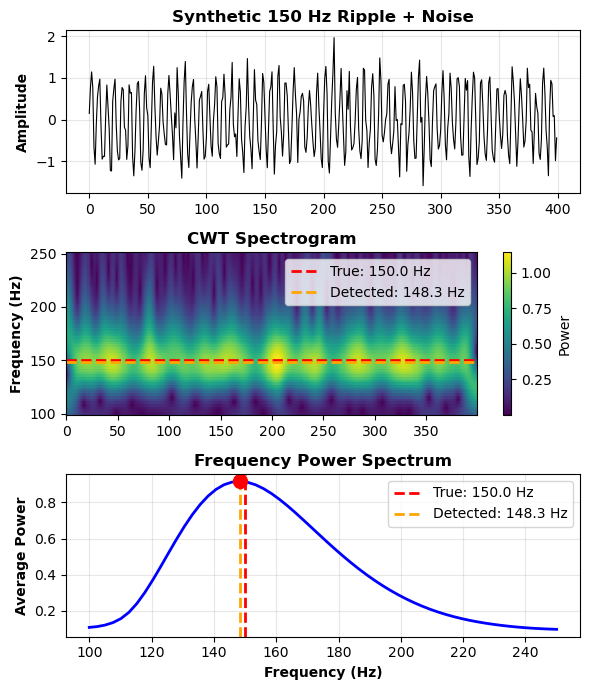


CWT VALIDATION RESULTS
True frequency: 150.0 Hz
Detected frequency: 148.31 Hz
Frequency error: 1.69 Hz (1.1%)
Frequency resolution: 2.54 Hz
✅ CWT is ACCURATE (error < 5 Hz)


In [24]:
# ========== VALIDATE CWT ACCURACY WITH SYNTHETIC SIGNAL ==========
import importlib
import swr_detection.swr_spectral_features
importlib.reload(swr_detection.swr_spectral_features)

import numpy as np
import matplotlib.pyplot as plt

# Create synthetic test signal: 150 Hz ripple embedded in noise
fs_test = 1000.0  # Match your LFP sampling rate
duration = 0.4  # 400ms
t_test = np.arange(0, duration, 1/fs_test)

# Pure 150 Hz sine wave (expected ripple frequency)
ripple_freq = 150.0
signal_150hz = np.sin(2 * np.pi * ripple_freq * t_test)

# Add some noise
np.random.seed(42)
noise = 0.3 * np.random.randn(len(t_test))
test_signal = signal_150hz + noise

# Compute CWT on test signal using your parameters
from swr_detection.swr_spectral_features import _cwt_optimized

freqs_test = np.linspace(100, 250, 60)  # Same as your config
cwt_result = _cwt_optimized(
    test_signal, 
    fs_test, 
    freqs_test,
    boundary='mirror',
    n_workers=4,
    verbose=False
)

# Find peak frequency
power_avg = np.mean(cwt_result, axis=1)
peak_idx = np.argmax(power_avg)
detected_freq = freqs_test[peak_idx]

# Plot validation
fig, axes = plt.subplots(3, 1, figsize=(6, 7))

# 1. Test signal
axes[0].plot(t_test * 1000, test_signal, 'k-', lw=0.8)
axes[0].set_ylabel('Amplitude', fontweight='bold')
axes[0].set_title(f'Synthetic 150 Hz Ripple + Noise', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. CWT spectrogram
im = axes[1].pcolormesh(t_test * 1000, freqs_test, cwt_result, shading='auto', cmap='viridis')
axes[1].axhline(ripple_freq, color='r', linestyle='--', lw=2, label=f'True: {ripple_freq} Hz')
axes[1].axhline(detected_freq, color='orange', linestyle='--', lw=2, label=f'Detected: {detected_freq:.1f} Hz')
axes[1].set_ylabel('Frequency (Hz)', fontweight='bold')
axes[1].set_title('CWT Spectrogram', fontweight='bold')
axes[1].legend(loc='upper right')
plt.colorbar(im, ax=axes[1], label='Power')

# 3. Power spectrum (averaged across time)
axes[2].plot(freqs_test, power_avg, 'b-', lw=2)
axes[2].axvline(ripple_freq, color='r', linestyle='--', lw=2, label=f'True: {ripple_freq} Hz')
axes[2].axvline(detected_freq, color='orange', linestyle='--', lw=2, label=f'Detected: {detected_freq:.1f} Hz')
axes[2].plot(detected_freq, power_avg[peak_idx], 'ro', markersize=10)
axes[2].set_xlabel('Frequency (Hz)', fontweight='bold')
axes[2].set_ylabel('Average Power', fontweight='bold')
axes[2].set_title('Frequency Power Spectrum', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print validation results
error = abs(detected_freq - ripple_freq)
print("\n" + "=" * 60)
print("CWT VALIDATION RESULTS")
print("=" * 60)
print(f"True frequency: {ripple_freq} Hz")
print(f"Detected frequency: {detected_freq:.2f} Hz")
print(f"Frequency error: {error:.2f} Hz ({error/ripple_freq*100:.1f}%)")
print(f"Frequency resolution: {(freqs_test[1] - freqs_test[0]):.2f} Hz")

if error < 5.0:
    print(f"✅ CWT is ACCURATE (error < 5 Hz)")
else:
    print(f"⚠️ WARNING: CWT error is HIGH (error = {error:.2f} Hz)")
    print(f"   Expected error < 5 Hz for {ripple_freq} Hz signal")
print("=" * 60)

In [18]:
# --- View detected events as DataFrame ---
events_df = pd.DataFrame(detector.swr_events)
print(events_df.columns)
print(f"Number of events found: {len(detector.swr_events)}")

Index(['event_id', 'channel', 'start_idx', 'end_idx', 'start_time', 'end_time',
       'duration', 'basic_start_idx', 'basic_end_idx', 'basic_duration',
       'basic_start_time', 'basic_end_time', 'hysteresis_start_idx',
       'hysteresis_end_idx', 'hysteresis_duration', 'hysteresis_start_time',
       'hysteresis_end_time', 'hmm_ripple_start_idx', 'hmm_ripple_end_idx',
       'hmm_ripple_duration', 'hmm_mua_start_idx', 'hmm_mua_end_idx',
       'hmm_mua_duration', 'mua_high_start', 'mua_high_end',
       'ripple_start_idx', 'ripple_end_idx', 'ripple_start_time',
       'ripple_end_time', 'ripple_duration', 'mua_start_idx', 'mua_end_idx',
       'mua_start_time', 'mua_end_time', 'mua_duration', 'combined_start_idx',
       'combined_end_idx', 'combined_start_time', 'combined_end_time',
       'combined_duration', 'peak_time', 'peak_power', 'peak_times',
       'event_type', 'detection_type', 'ripple_high_threshold',
       'ripple_low_threshold', 'mua_threshold', 'ripple_peak_freq',


In [25]:
# Export both boundary types to CSV for further analysis
export_data = []

for i, event in enumerate(detector.swr_events):
    ripple_start = event.get('combined_start_time', event.get('start_time'))
    ripple_end = event.get('combined_end_time', event.get('end_time'))
    mua_start = event.get('mua_high_start')
    mua_end = event.get('mua_high_end')
    
    if ripple_start and ripple_end and mua_start and mua_end:
        ripple_dur = (ripple_end - ripple_start) * 1000
        mua_dur = (mua_end - mua_start) * 1000
        extension = mua_dur - ripple_dur
        
        export_data.append({
            'event_id': event.get('event_id', i),
            'channel': event.get('channel'),
            'peak_time': event.get('peak_time'),
            'peak_power': event.get('peak_power'),
            # Ripple boundaries
            'ripple_start_time': ripple_start,
            'ripple_end_time': ripple_end,
            'ripple_duration_ms': ripple_dur,
            # MUA boundaries
            'mua_start_time': mua_start,
            'mua_end_time': mua_end,
            'mua_duration_ms': mua_dur,
            # Comparison
            'extension_ms': extension,
            'extension_percent': (extension / ripple_dur) * 100
        })

# Create DataFrame
events_df = pd.DataFrame(export_data)

# Display first few events
print("\n" + "=" * 80)
print("EXPORTED EVENT DATA WITH BOTH BOUNDARY TYPES")
print("=" * 80)
print(f"\nTotal events: {len(events_df)}\n")
print(events_df.head(10).to_string(index=False))

# Save to CSV (optional - uncomment to save)
# output_path = r"D:\Spikeinterface_practice\s4_rec\swr_events_with_mua_boundaries.csv"
# events_df.to_csv(output_path, index=False)
# print(f"\n✅ Saved to: {output_path}")

print("\n📊 Quick Summary:")
print(f"   Average ripple duration: {events_df['ripple_duration_ms'].mean():.1f} ms")
print(f"   Average MUA duration: {events_df['mua_duration_ms'].mean():.1f} ms")
print(f"   Average extension: {events_df['extension_ms'].mean():.1f} ms ({events_df['extension_percent'].mean():.1f}%)")


EXPORTED EVENT DATA WITH BOTH BOUNDARY TYPES

Total events: 1625

 event_id  channel  peak_time  peak_power  ripple_start_time  ripple_end_time  ripple_duration_ms  mua_start_time  mua_end_time  mua_duration_ms  extension_ms  extension_percent
        1        0      0.770   13.603957              0.686            0.802               116.0            0.52         0.820            300.0         184.0         158.620690
        2        0      3.336    2.962104              3.273            3.395               122.0            3.27         3.400            130.0           8.0           6.557377
        3        0      4.729    5.771030              4.710            4.747                37.0            4.61         4.940            330.0         293.0         791.891892
        4        0      5.048    6.383685              5.035            5.122                87.0            5.03         5.275            245.0         158.0         181.609195
        7        0      5.309   12.026089  

In [3]:
import cupy
print("CuPy version:", cupy.__version__)
print("CUDA runtime version:", cupy.cuda.runtime.runtimeGetVersion())
print("CUDA driver version:", cupy.cuda.runtime.driverGetVersion())
print("CUDA device count:", cupy.cuda.runtime.getDeviceCount())

CuPy version: 13.6.0
CUDA runtime version: 12090
CUDA driver version: 12060
CUDA device count: 1


In [4]:
import cupy
print("GPU name:", cupy.cuda.runtime.getDeviceProperties(0)['name'].decode())

GPU name: NVIDIA GeForce RTX 4070 SUPER
